In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('train_preprocess.tsv', sep='\t', header=None, names = ['Text', 'Label'])
df.head()

,Text,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [2]:
df.shape

(11000, 2)

In [3]:
df.Label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: Label, dtype: int64

<h1>Cleansing

In [4]:
import re

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ',string)
    return string

df['text_clean'] = df.Text.apply(cleansing)
df

,Text,Label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...
...,...,...,...
10995,tidak kecewa,positive,tidak kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormati partai partai yang telah berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi di tol pasteur sudah macet parah b...


<h1>Tokenizer

In [5]:
df.head()

,Text,Label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [6]:
neg = df.loc[df['Label']=='negative'].Text.tolist()
pos = df.loc[df['Label']=='positive'].Text.tolist()
neu = df.loc[df['Label']=='neutral'].Text.tolist()


neg_label = df.loc[df['Label']=='negative'].Label.tolist()
pos_label = df.loc[df['Label']=='positive'].Label.tolist()
neu_label = df.loc[df['Label']=='neutral'].Label.tolist()

total_data = pos + neg + neu
label = pos_label + neg_label + neu_label

In [7]:
print(len(total_data))

11000


In [8]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol= pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created !")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created !')


tokenizer.pickle has created !
x_pad_sequences.pickle has created !


In [9]:
Y = pd.get_dummies(label)
Y = Y.values

with open('y_label.pickle','wb') as handle:
  pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('y_label.pickle has created !')

y_label.pickle has created !


In [10]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_label.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=1)

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8800, 96) (8800, 3) (2200, 96) (2200, 3)


<h1>LSTM Modeling

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten
from tensorflow.keras import backend as K

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
adam = optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min',verbose = 1)
history = model.fit(X_train, y_train, epochs=10, batch_size=12, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Epoch 1/10



734/734 [==============================] - 139s 185ms/step - loss: 0.4708 - accuracy: 0.8136 - val_loss: 0.3752 - val_accuracy: 0.8632
Epoch 2/10
734/734 [==============================] - 135s 184ms/step - loss: 0.2066 - accuracy: 0.9277 - val_loss: 0.3675 - val_accuracy: 0.8609
Epoch 3/10
734/734 [==============================] - 134s 183ms/step - loss: 0.1106 - accuracy: 0.9585 - val_loss: 0.4000 - val_accuracy: 0.8600
Epoch 3: early stopping


In [14]:
from sklearn import metrics

pred = model.predict(X_test)
matrix_test = metrics.classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print("Testing Selesai")
print(matrix_test)

69/69 [==============================] - 1s 12ms/step
Testing Selesai
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       699
           1       0.73      0.80      0.76       219
           2       0.91      0.90      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.82      0.83      0.83      2200
weighted avg       0.86      0.86      0.86      2200



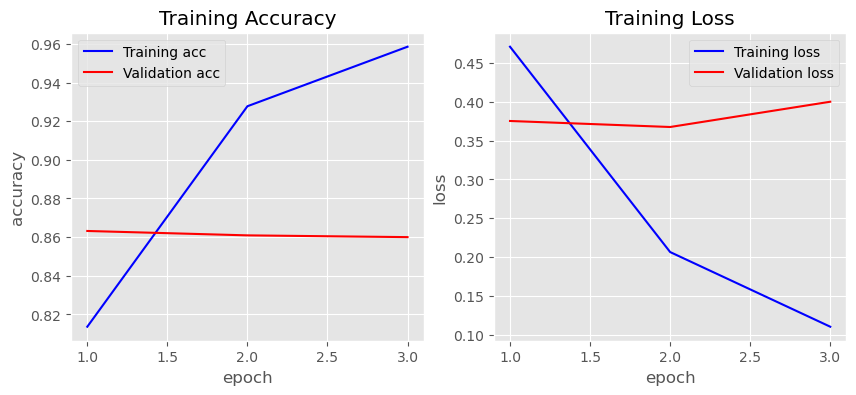

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
%matplotlib inline
plot_history(history)

In [16]:
model.save('model.h5')
print("Selesai")

Selesai


In [20]:
import re
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 310ms/step
Text:   rasa syukur  cukup  
Sentiment:  negative
